In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split

import string, re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.utils import text_dataset_from_directory, plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, TextVectorization,Conv1D, MaxPooling1D, Input, Dropout, concatenate

In [2]:
data = pd.read_csv('/kaggle/input/imdb-movie-ratings-sentiment-analysis/movie.csv')

X = data.drop('label', axis=1)
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.2, random_state=23)

In [3]:
vocab_size = 25000

In [15]:
## creating a function to clean the text using custom standardization
def clean_doc(doc):
    # removing the punctuations
    tokens = tf.strings.regex_replace(doc, '[%s]' % re.escape(string.punctuation), '')
    
    # removing un-printable characters
    tokens = tf.strings.regex_replace(tokens, '[^%s]' % re.escape(string.printable), '')
    
    # removing english stopwords
    stop_words = set(stopwords.words('english'))
    for word in stop_words:
        tokens = tf.strings.regex_replace(tokens, f'{word}', "")
    
    ## lowering the case of all the text
    tokens = tf.strings.lower(tokens)
    
    return tokens

In [16]:
# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length for Text Vectorization layer as all samples are not of the same length.

sequence_length = 300

vectorize_layer1 = tf.keras.layers.TextVectorization(
    standardize = clean_doc,
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = sequence_length)

vectorize_layer2 = tf.keras.layers.TextVectorization(
    standardize = clean_doc,
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = sequence_length)

vectorize_layer3 = tf.keras.layers.TextVectorization(
    standardize = clean_doc,
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = sequence_length)

# Make a text-only dataset (no labels) and call `Dataset.adapt` to build the
# vocabulary.
vectorize_layer1.adapt(X_train)
vectorize_layer2.adapt(X_train)
vectorize_layer3.adapt(X_train)

In [6]:
## Channel 1
input1 = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
encoded_input1 = vectorize_layer1(input1)
embedding1 = tf.keras.layers.Embedding(vocab_size, 100)(encoded_input1)
conv1 = tf.keras.layers.Conv1D(32, 4, activation='relu')(embedding1)
drop1 = tf.keras.layers.Dropout(0.5)(conv1)
pool1 = tf.keras.layers.MaxPooling1D()(drop1)
flat1 = tf.keras.layers.Flatten()(pool1)

## Channel 2
input2 = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
encoded_input2 = vectorize_layer2(input2)
embedding2 = tf.keras.layers.Embedding(vocab_size, 100)(encoded_input2)
conv2 = tf.keras.layers.Conv1D(32, 6, activation='relu')(embedding2)
drop2 = tf.keras.layers.Dropout(0.5)(conv2)
pool2 = tf.keras.layers.MaxPooling1D()(drop2)
flat2 = tf.keras.layers.Flatten()(pool2)

## Channel 3
input3 = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
encoded_input3 = vectorize_layer3(input3)
embedding3 = tf.keras.layers.Embedding(vocab_size, 100)(encoded_input3)
conv3 = tf.keras.layers.Conv1D(32, 4, activation='relu')(embedding3)
drop3 = tf.keras.layers.Dropout(0.5)(conv3)
pool3 = tf.keras.layers.MaxPooling1D()(drop3)
flat3 = tf.keras.layers.Flatten()(pool3)

## concatenating all the flat layers
merged = tf.keras.layers.concatenate([flat1, flat2, flat3])

## creating dense layer
dense1 = tf.keras.layers.Dense(10, activation='relu')(merged)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

## creating a model
model = tf.keras.models.Model(inputs = [input1, input2, input3], outputs = outputs)

In [7]:
## compiling a model
model.compile(
optimizer="adam",
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=["accuracy"])

In [8]:
## summarizing a model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 300)          0           input_1[0][0]                    
______________________________________________________________________________________________

In [9]:
## Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)

In [12]:
## training a model Multi_channel CNN
history = model.fit([X_train, X_train, X_train],
                    np.array(y_train),
                    validation_data=([X_val, X_val, X_val], y_val),
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
800/800 [==============================] - 24s 30ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6934 - val_accuracy: 0.4950
Epoch 2/10
800/800 [==============================] - 23s 29ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.4950
Epoch 3/10
800/800 [==============================] - 23s 29ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6933 - val_accuracy: 0.4950
Epoch 4/10
800/800 [==============================] - 23s 29ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 5/10
800/800 [==============================] - 23s 29ms/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 6/10
800/800 [==============================] - 23s 29ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6934 - val_accuracy: 0.4950
Epoch 7/10
800/800 [==============================] - 23s 29ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy:

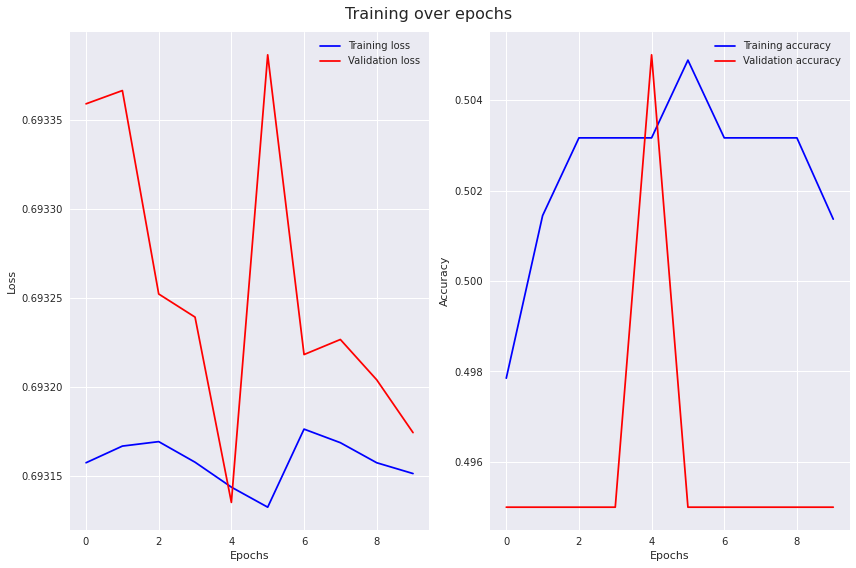

In [13]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
fig.suptitle('Training over epochs', fontsize=16)

ax1.plot(history.history['loss'],color='blue',label='Training loss')
ax1.plot(history.history['val_loss'],color='red',label='Validation loss')
ax1.legend()
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')

ax2.plot(history.history['accuracy'],color='blue',label='Training accuracy')
ax2.plot(history.history['val_accuracy'],color='red',label='Validation accuracy')
ax2.legend()
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')

plt.tight_layout()

In [14]:
test_data_loss, test_data_accuracy = model.evaluate([X_test, X_test, X_test], y_test, batch_size=512)

print(f"Test data loss {test_data_loss}\n")
print(f"Test data accuracy {test_data_accuracy}")

16/16 [==============================] - 5s 241ms/step - loss: 0.6931 - accuracy: 0.5038
Test data loss 0.6931383013725281

Test data accuracy 0.5037500262260437
